# Análisis Exploratorio de Datos (EDA) - Pipeline Genérico

Este notebook proporciona un análisis exploratorio completo y automático para cualquier dataset.

**Funcionalidades:**
- Carga automática de datos desde CSV
- Detección automática de tipos de datos
- Análisis estadístico descriptivo
- Detección de valores faltantes y outliers
- Visualizaciones automáticas por tipo de variable
- Correlación entre variables numéricas
- Distribución de variables categóricas
- Resumen ejecutivo del dataset

In [11]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configurar estilos visuales
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 1. Cargar el Dataset

Carga de datos desde CSV. Por defecto busca `Base_de_datos.csv` en la raíz del proyecto.

In [12]:
import os
import json

# Posibles rutas donde puede estar el dataset
possible_paths = [
    "../../alzheimers_disease_data.csv",
    "../../../alzheimers_disease_data.csv", 
    "../../data/alzheimers_disease_data.csv",
    "../../../data/alzheimers_disease_data.csv",
    "alzheimers_disease_data.csv",
    "./data/alzheimers_disease_data.csv"
]

# Cargar configuración
config_path = "../../config.json"
data_path = None

if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        config = json.load(f)
        configured_path = config.get('data_path', '')
        if configured_path and os.path.exists(configured_path):
            data_path = configured_path

# Si no se encontró en config, buscar en rutas posibles
if data_path is None:
    for path in possible_paths:
        if os.path.exists(path):
            data_path = path
            break

# Si aún no se encuentra, mostrar error informativo
if data_path is None:
    print("❌ No se encontró el archivo del dataset.")
    print("📁 Rutas buscadas:")
    for path in possible_paths:
        print(f"   • {path}")
    print("\n💡 Soluciones:")
    print("   1. Colocar 'alzheimers_disease_data.csv' en la carpeta raíz del proyecto")
    print("   2. Actualizar la ruta en config.json")
    print("   3. Verificar la estructura de carpetas del proyecto")
    raise FileNotFoundError("Dataset no encontrado en ninguna de las rutas esperadas")

# Cargar dataset
df = pd.read_csv(data_path)

print(f"✓ Dataset cargado desde: {data_path}")
print(f"  Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"\n  Primeras filas del dataset:")
df.head()

✓ Dataset cargado desde: ../../../alzheimers_disease_data.csv
  Dimensiones: 2149 filas × 35 columnas

  Primeras filas del dataset:


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


## 2. Información General del Dataset

Inspección de tipos de datos, memoria utilizada y estructura general.

In [13]:
# Crear resumen de información
print("="*80)
print("INFORMACIÓN GENERAL DEL DATASET")
print("="*80)
print(f"\nDimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")

print("TIPOS DE DATOS:")
print("-" * 80)
dtype_info = pd.DataFrame({
    'Columna': df.columns,
    'Tipo': df.dtypes,
    'No Nulos': df.count(),
    'Nulos': df.isnull().sum(),
    '% Nulos': (df.isnull().sum() / len(df) * 100).round(2)
})
print(dtype_info.to_string(index=False))
print("\n" + "="*80)

INFORMACIÓN GENERAL DEL DATASET

Dimensiones: 2149 filas × 35 columnas
Memoria utilizada: 0.69 MB

TIPOS DE DATOS:
--------------------------------------------------------------------------------
                  Columna    Tipo  No Nulos  Nulos  % Nulos
                PatientID   int64      2149      0      0.0
                      Age   int64      2149      0      0.0
                   Gender   int64      2149      0      0.0
                Ethnicity   int64      2149      0      0.0
           EducationLevel   int64      2149      0      0.0
                      BMI float64      2149      0      0.0
                  Smoking   int64      2149      0      0.0
       AlcoholConsumption float64      2149      0      0.0
         PhysicalActivity float64      2149      0      0.0
              DietQuality float64      2149      0      0.0
             SleepQuality float64      2149      0      0.0
  FamilyHistoryAlzheimers   int64      2149      0      0.0
    CardiovascularDiseas

## 3. Estadísticas Descriptivas

Análisis estadístico automático según el tipo de variable.

In [14]:
# Estadísticas para variables numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("\n" + "="*80)
print("ESTADÍSTICAS NUMÉRICAS")
print("="*80 + "\n")

if numeric_cols:
    stats = df[numeric_cols].describe().T
    stats['Rango'] = df[numeric_cols].max() - df[numeric_cols].min()
    stats['Asimetría'] = df[numeric_cols].skew()
    stats['Curtosis'] = df[numeric_cols].kurtosis()
    print(stats.round(3))
else:
    print("No hay variables numéricas en el dataset.")

print("\n" + "="*80)
print("ESTADÍSTICAS CATEGÓRICAS")
print("="*80 + "\n")

if categorical_cols:
    for col in categorical_cols:
        print(f"📊 {col}")
        print(f"   Valores únicos: {df[col].nunique()}")
        print(f"   Más frecuente: {df[col].value_counts().index[0]} ({df[col].value_counts().values[0]} veces)")
        print(f"   Distribución:\n{df[col].value_counts()}\n")
else:
    print("No hay variables categóricas en el dataset.")


ESTADÍSTICAS NUMÉRICAS

                            count      mean      std       min       25%  \
PatientID                  2149.0  5825.000  620.507  4751.000  5288.000   
Age                        2149.0    74.909    8.990    60.000    67.000   
Gender                     2149.0     0.506    0.500     0.000     0.000   
Ethnicity                  2149.0     0.698    0.996     0.000     0.000   
EducationLevel             2149.0     1.287    0.905     0.000     1.000   
BMI                        2149.0    27.656    7.217    15.009    21.611   
Smoking                    2149.0     0.289    0.453     0.000     0.000   
AlcoholConsumption         2149.0    10.039    5.758     0.002     5.140   
PhysicalActivity           2149.0     4.920    2.857     0.004     2.571   
DietQuality                2149.0     4.993    2.909     0.009     2.458   
SleepQuality               2149.0     7.051    1.764     4.003     5.483   
FamilyHistoryAlzheimers    2149.0     0.252    0.434     0.000 

## 4. Análisis de Valores Faltantes

Detección y visualización de datos faltantes.

In [15]:
# Análisis de valores faltantes
print("\n" + "="*80)
print("ANÁLISIS DE VALORES FALTANTES")
print("="*80 + "\n")

missing_data = pd.DataFrame({
    'Columna': df.columns,
    'Nulos': df.isnull().sum(),
    '% Nulos': (df.isnull().sum() / len(df) * 100).round(2),
    'Tipo': df.dtypes
})

missing_data = missing_data[missing_data['Nulos'] > 0].sort_values('% Nulos', ascending=False)

if len(missing_data) > 0:
    print("Columnas con valores faltantes:")
    print(missing_data.to_string(index=False))
    
    # Visualizar patrones de valores faltantes
    if len(missing_data) <= 10:
        fig, ax = plt.subplots(figsize=(10, 4))
        missing_data_sorted = missing_data.sort_values('% Nulos', ascending=True)
        ax.barh(missing_data_sorted['Columna'], missing_data_sorted['% Nulos'], color='coral')
        ax.set_xlabel('% de Valores Faltantes')
        ax.set_title('Distribución de Valores Faltantes')
        ax.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("✓ No hay valores faltantes en el dataset")


ANÁLISIS DE VALORES FALTANTES

✓ No hay valores faltantes en el dataset


## 5. Visualización de Distribuciones de Variables Numéricas

Histogramas y gráficos de densidad para cada variable numérica.


📈 Visualizando 34 variable(s) numérica(s)...



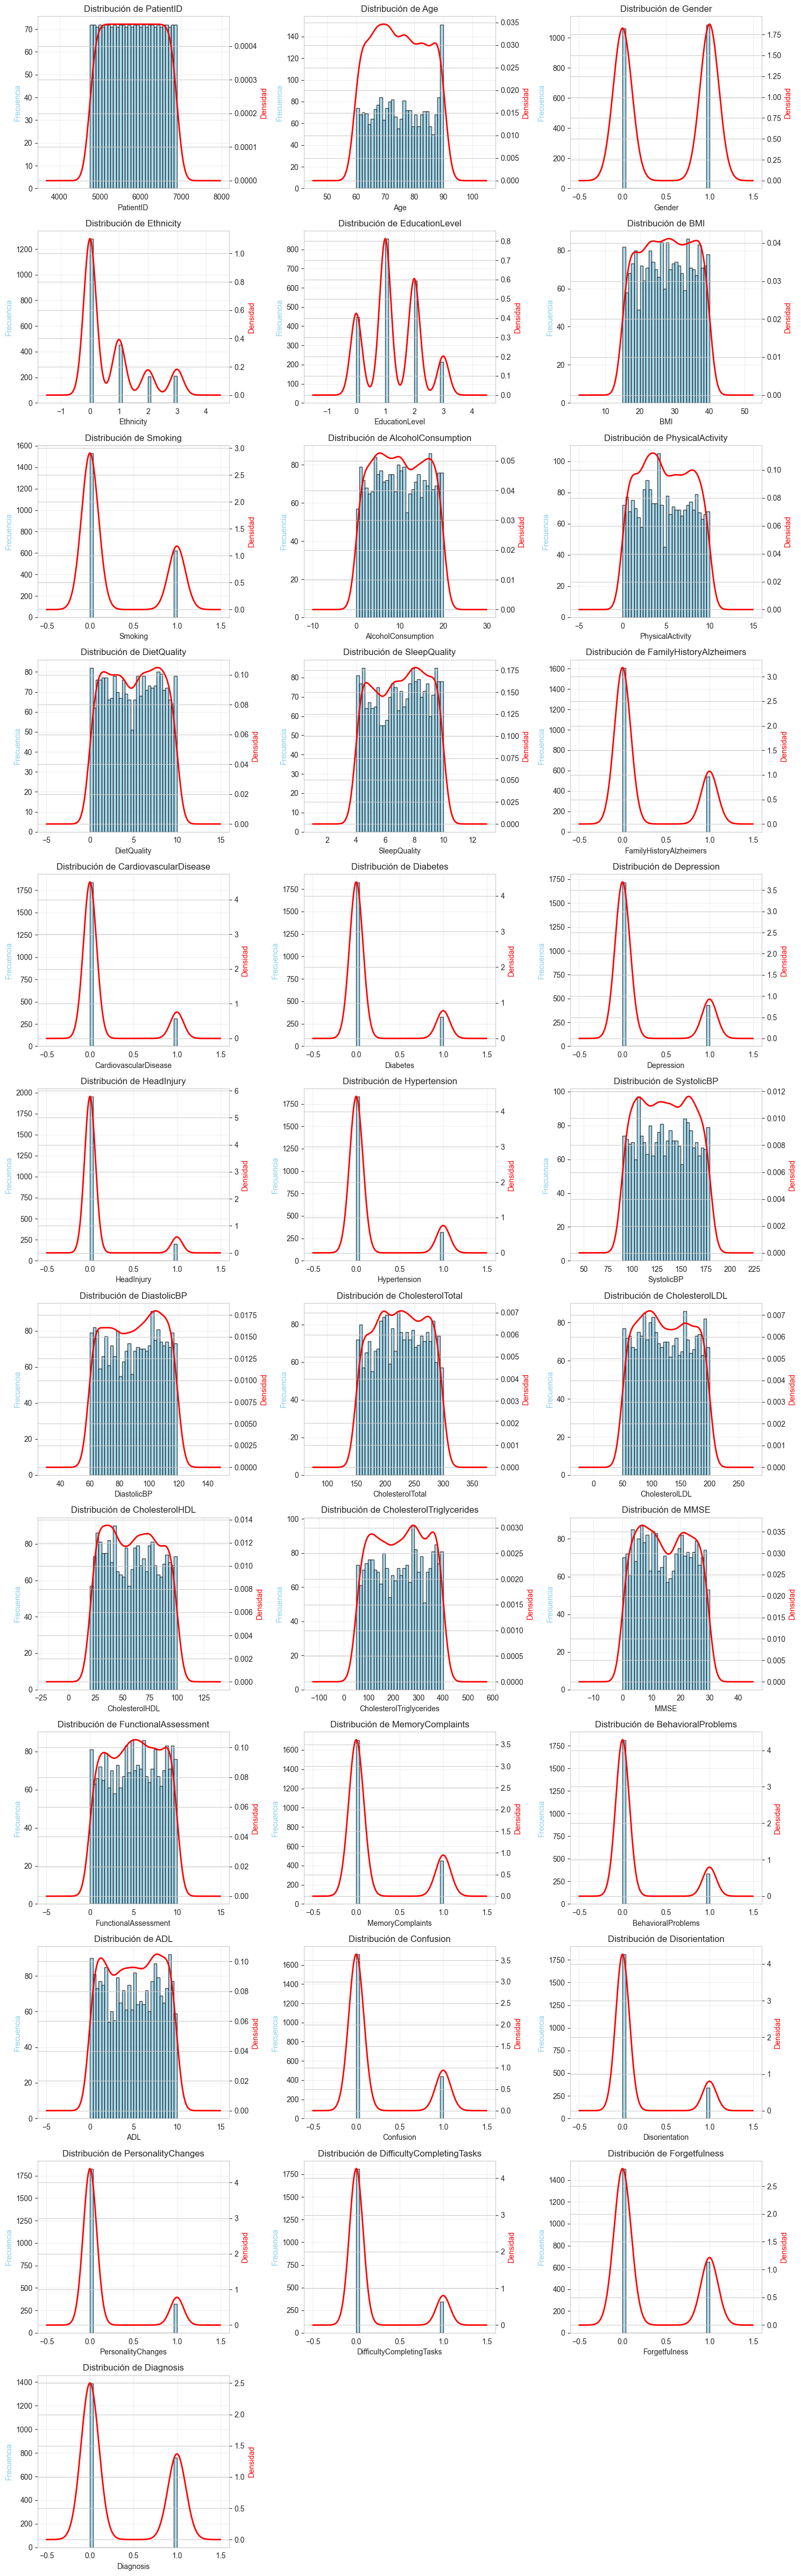

In [16]:
if numeric_cols:
    print(f"\n📈 Visualizando {len(numeric_cols)} variable(s) numérica(s)...\n")
    
    # Calcular número de filas y columnas para subplot
    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if len(numeric_cols) > 1 else [axes]
    
    for idx, col in enumerate(numeric_cols):
        ax = axes[idx]
        
        # Histograma con distribución normal
        ax.hist(df[col].dropna(), bins=30, alpha=0.7, edgecolor='black', color='skyblue')
        ax2 = ax.twinx()
        df[col].dropna().plot(kind='density', ax=ax2, color='red', linewidth=2)
        
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia', color='skyblue')
        ax2.set_ylabel('Densidad', color='red')
        ax.set_title(f'Distribución de {col}')
        ax.grid(alpha=0.3)
    
    # Eliminar subplots vacíos
    for idx in range(len(numeric_cols), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
else:
    print("No hay variables numéricas para visualizar.")

## 6. Análisis de Outliers

Detección de outliers usando el método del Rango Intercuartílico (IQR).


ANÁLISIS DE OUTLIERS (Método IQR)

⚠️  Ethnicity: 211 outliers (9.82%)
⚠️  CardiovascularDisease: 310 outliers (14.43%)
⚠️  Diabetes: 324 outliers (15.08%)
⚠️  Depression: 431 outliers (20.06%)
⚠️  HeadInjury: 199 outliers (9.26%)
⚠️  Hypertension: 320 outliers (14.89%)
⚠️  MemoryComplaints: 447 outliers (20.8%)
⚠️  BehavioralProblems: 337 outliers (15.68%)
⚠️  Confusion: 441 outliers (20.52%)
⚠️  Disorientation: 340 outliers (15.82%)
⚠️  PersonalityChanges: 324 outliers (15.08%)
⚠️  DifficultyCompletingTasks: 341 outliers (15.87%)

                  Columna  Outliers  % Outliers  Rango Válido
                Ethnicity       211        9.82 [-1.50, 2.50]
    CardiovascularDisease       310       14.43  [0.00, 0.00]
                 Diabetes       324       15.08  [0.00, 0.00]
               Depression       431       20.06  [0.00, 0.00]
               HeadInjury       199        9.26  [0.00, 0.00]
             Hypertension       320       14.89  [0.00, 0.00]
         MemoryComplaints 

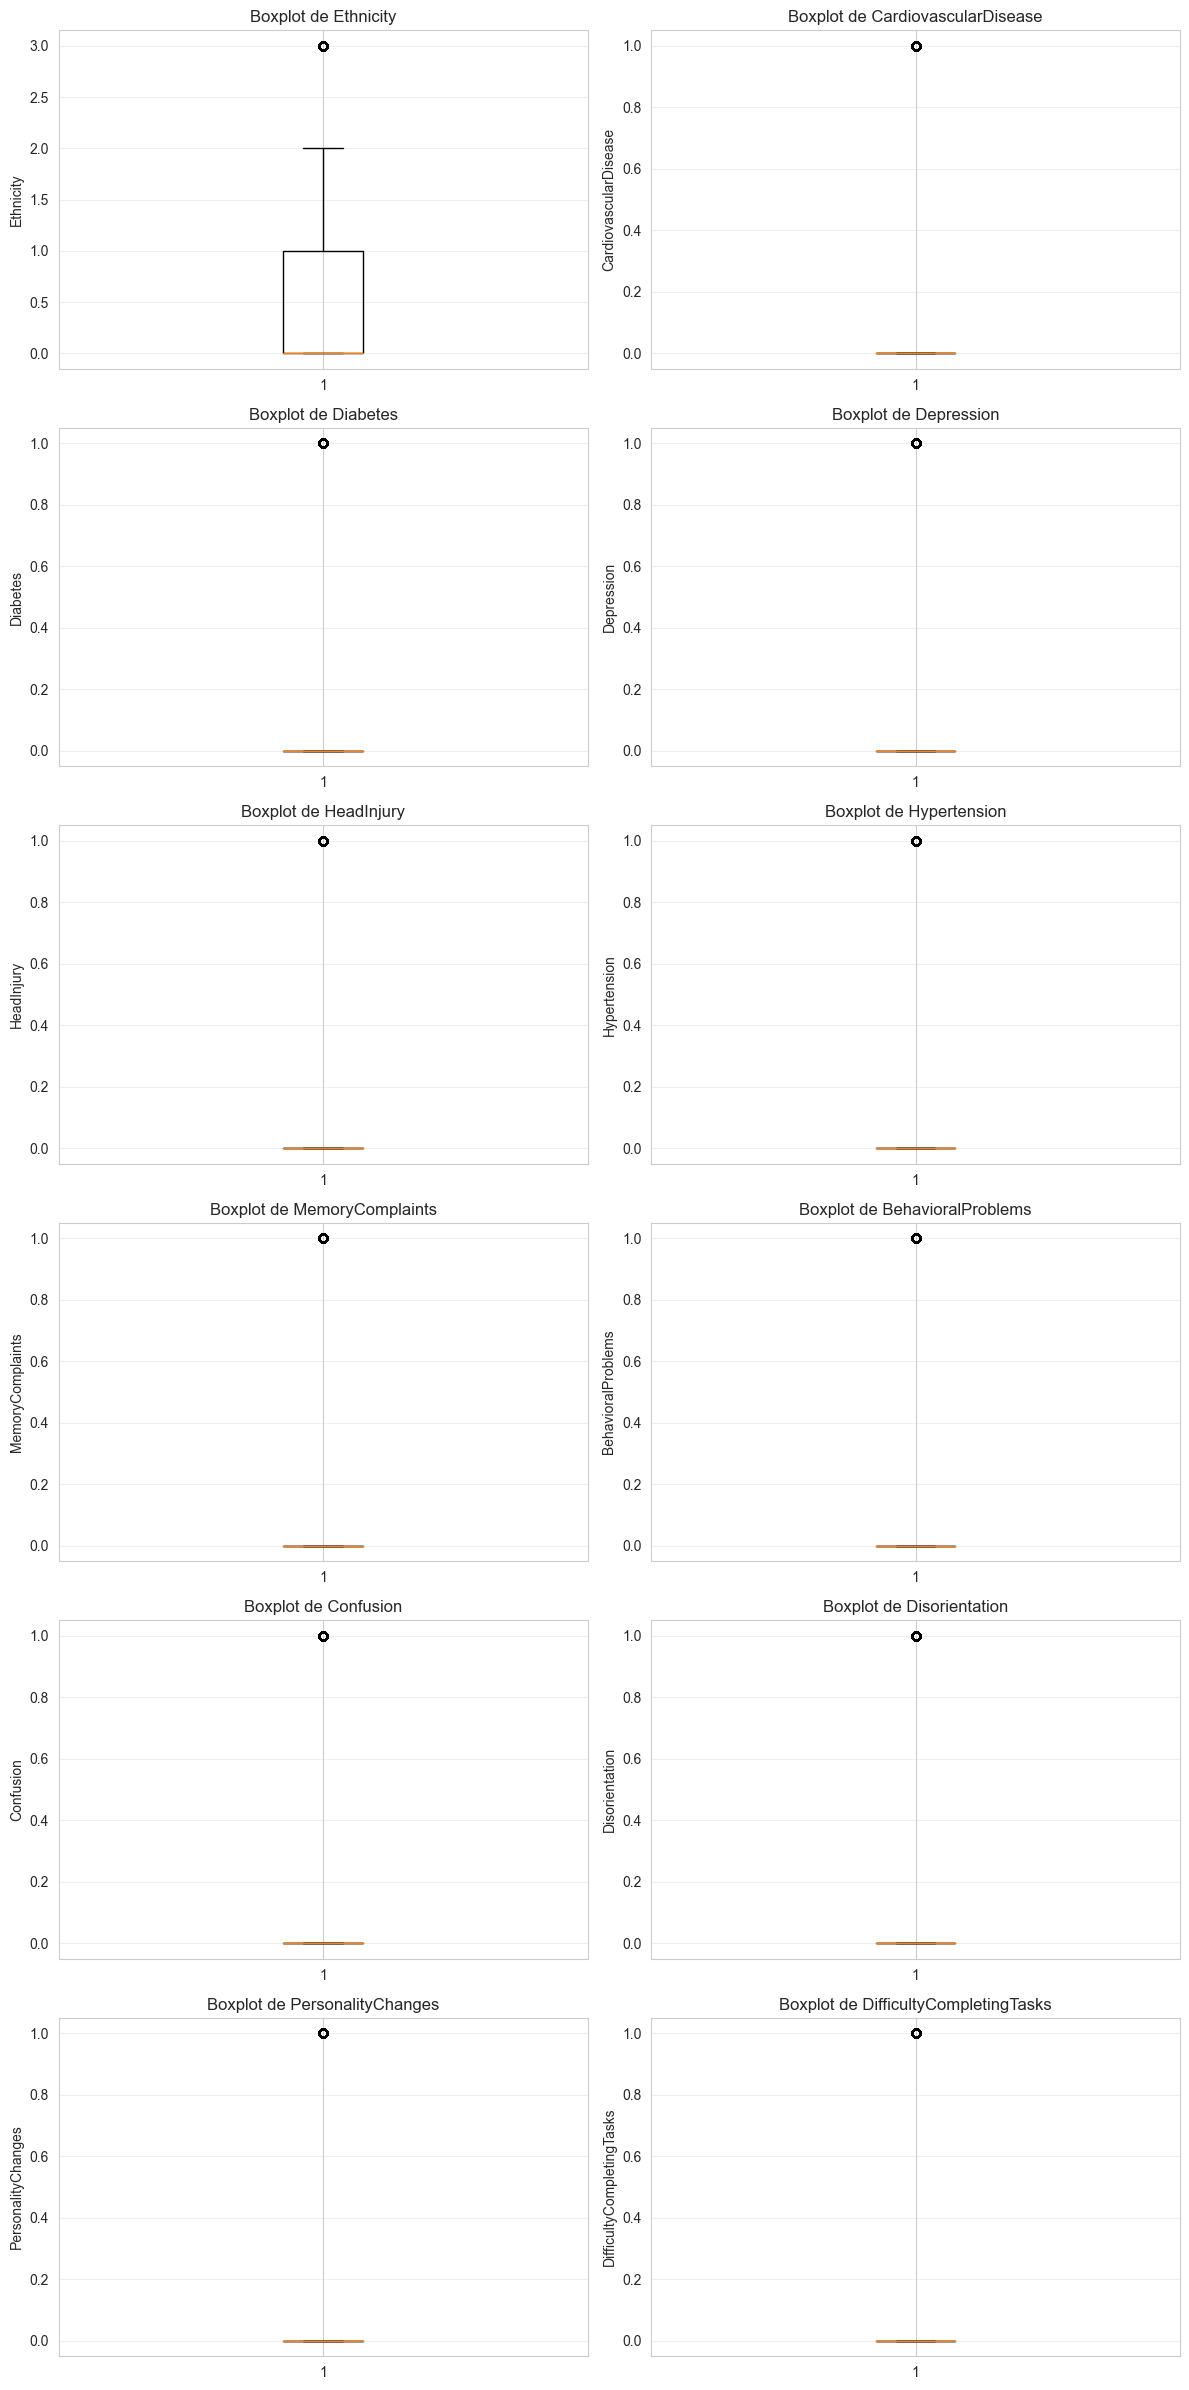

In [17]:
# Detección de outliers usando IQR
print("\n" + "="*80)
print("ANÁLISIS DE OUTLIERS (Método IQR)")
print("="*80 + "\n")

outlier_summary = []

if numeric_cols:
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        n_outliers = len(outliers)
        
        if n_outliers > 0:
            pct_outliers = round((n_outliers / len(df) * 100), 2)
            outlier_summary.append({
                'Columna': col,
                'Outliers': n_outliers,
                '% Outliers': pct_outliers,
                'Rango Válido': f"[{lower_bound:.2f}, {upper_bound:.2f}]"
            })
            print(f"⚠️  {col}: {n_outliers} outliers ({pct_outliers}%)")
    
    if outlier_summary:
        outlier_df = pd.DataFrame(outlier_summary)
        print("\n" + outlier_df.to_string(index=False))
        
        # Boxplot de variables con outliers - Disposición vertical
        if len(outlier_summary) > 0:
            n_plots = len(outlier_summary)
            n_cols = 2  # 2 columnas
            n_rows = (n_plots + n_cols - 1) // n_cols  # Calcula filas necesarias
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
            axes = axes.flatten()  # Convierte a array 1D para indexar fácilmente
            
            for idx, item in enumerate(outlier_summary):
                col = item['Columna']
                axes[idx].boxplot(df[col].dropna(), vert=True)
                axes[idx].set_ylabel(col)
                axes[idx].set_title(f'Boxplot de {col}')
                axes[idx].grid(alpha=0.3, axis='y')
            
            # Eliminar subplots vacíos si los hay
            for idx in range(len(outlier_summary), len(axes)):
                fig.delaxes(axes[idx])
            
            plt.tight_layout()
            plt.show()
    else:
        print("\n✓ No se detectaron outliers significativos en el dataset")
else:
    print("No hay variables numéricas para analizar outliers.")

## 7. Análisis de Variables Categóricas

Gráficos de barras para variables categóricas.


📊 Visualizando 1 variable(s) categórica(s)...



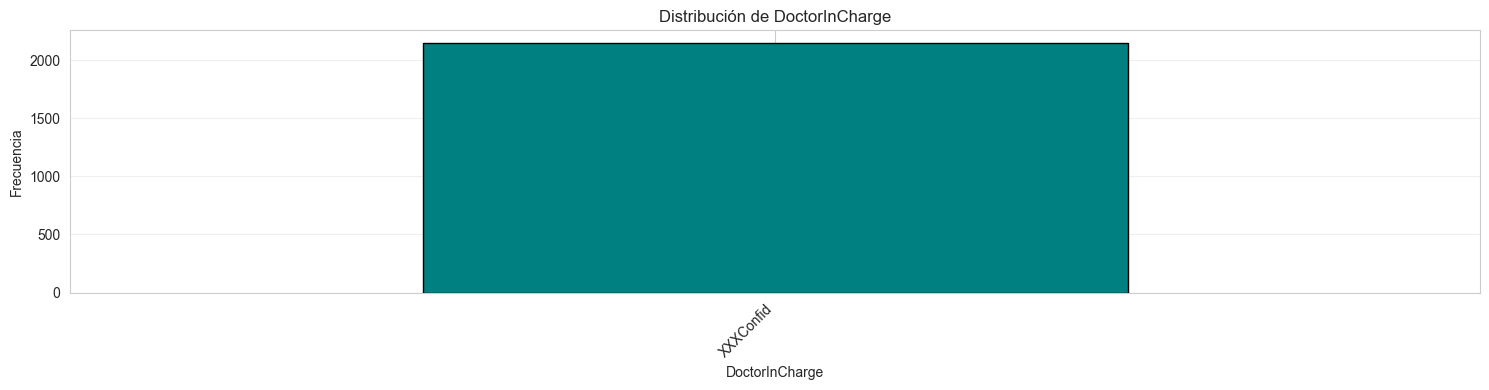

In [18]:
if categorical_cols:
    print(f"\n📊 Visualizando {len(categorical_cols)} variable(s) categórica(s)...\n")
    
    # Calcular número de filas y columnas para subplot
    n_cols = min(3, len(categorical_cols))
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if len(categorical_cols) > 1 else [axes]
    
    for idx, col in enumerate(categorical_cols):
        ax = axes[idx]
        
        # Contar valores y crear gráfico
        value_counts = df[col].value_counts()
        
        # Limitar a 10 categorías para mejor visualización
        if len(value_counts) > 10:
            value_counts = value_counts.head(10)
            title = f'Top 10 - {col} (hay más categorías)'
        else:
            title = f'Distribución de {col}'
        
        value_counts.plot(kind='bar', ax=ax, color='teal', edgecolor='black')
        ax.set_title(title)
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')
        ax.grid(axis='y', alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Eliminar subplots vacíos
    for idx in range(len(categorical_cols), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
else:
    print("No hay variables categóricas para visualizar.")

## 8. Análisis de Correlación

Correlación entre variables numéricas y heatmap de correlación.


MATRIZ DE CORRELACIÓN

                           PatientID    Age  Gender  Ethnicity  \
PatientID                      1.000  0.003  -0.044     -0.008   
Age                            0.003  1.000   0.029      0.028   
Gender                        -0.044  0.029   1.000     -0.004   
Ethnicity                     -0.008  0.028  -0.004      1.000   
EducationLevel                -0.002 -0.061  -0.007      0.027   
BMI                           -0.034 -0.016   0.006     -0.003   
Smoking                        0.022  0.020   0.017      0.031   
AlcoholConsumption            -0.021  0.007   0.004      0.008   
PhysicalActivity              -0.011 -0.010  -0.036      0.020   
DietQuality                   -0.018 -0.023   0.011     -0.018   
SleepQuality                  -0.026  0.049   0.007      0.029   
FamilyHistoryAlzheimers        0.002 -0.019   0.018      0.023   
CardiovascularDisease          0.018 -0.015   0.035      0.002   
Diabetes                      -0.004 -0.006  -0.018 

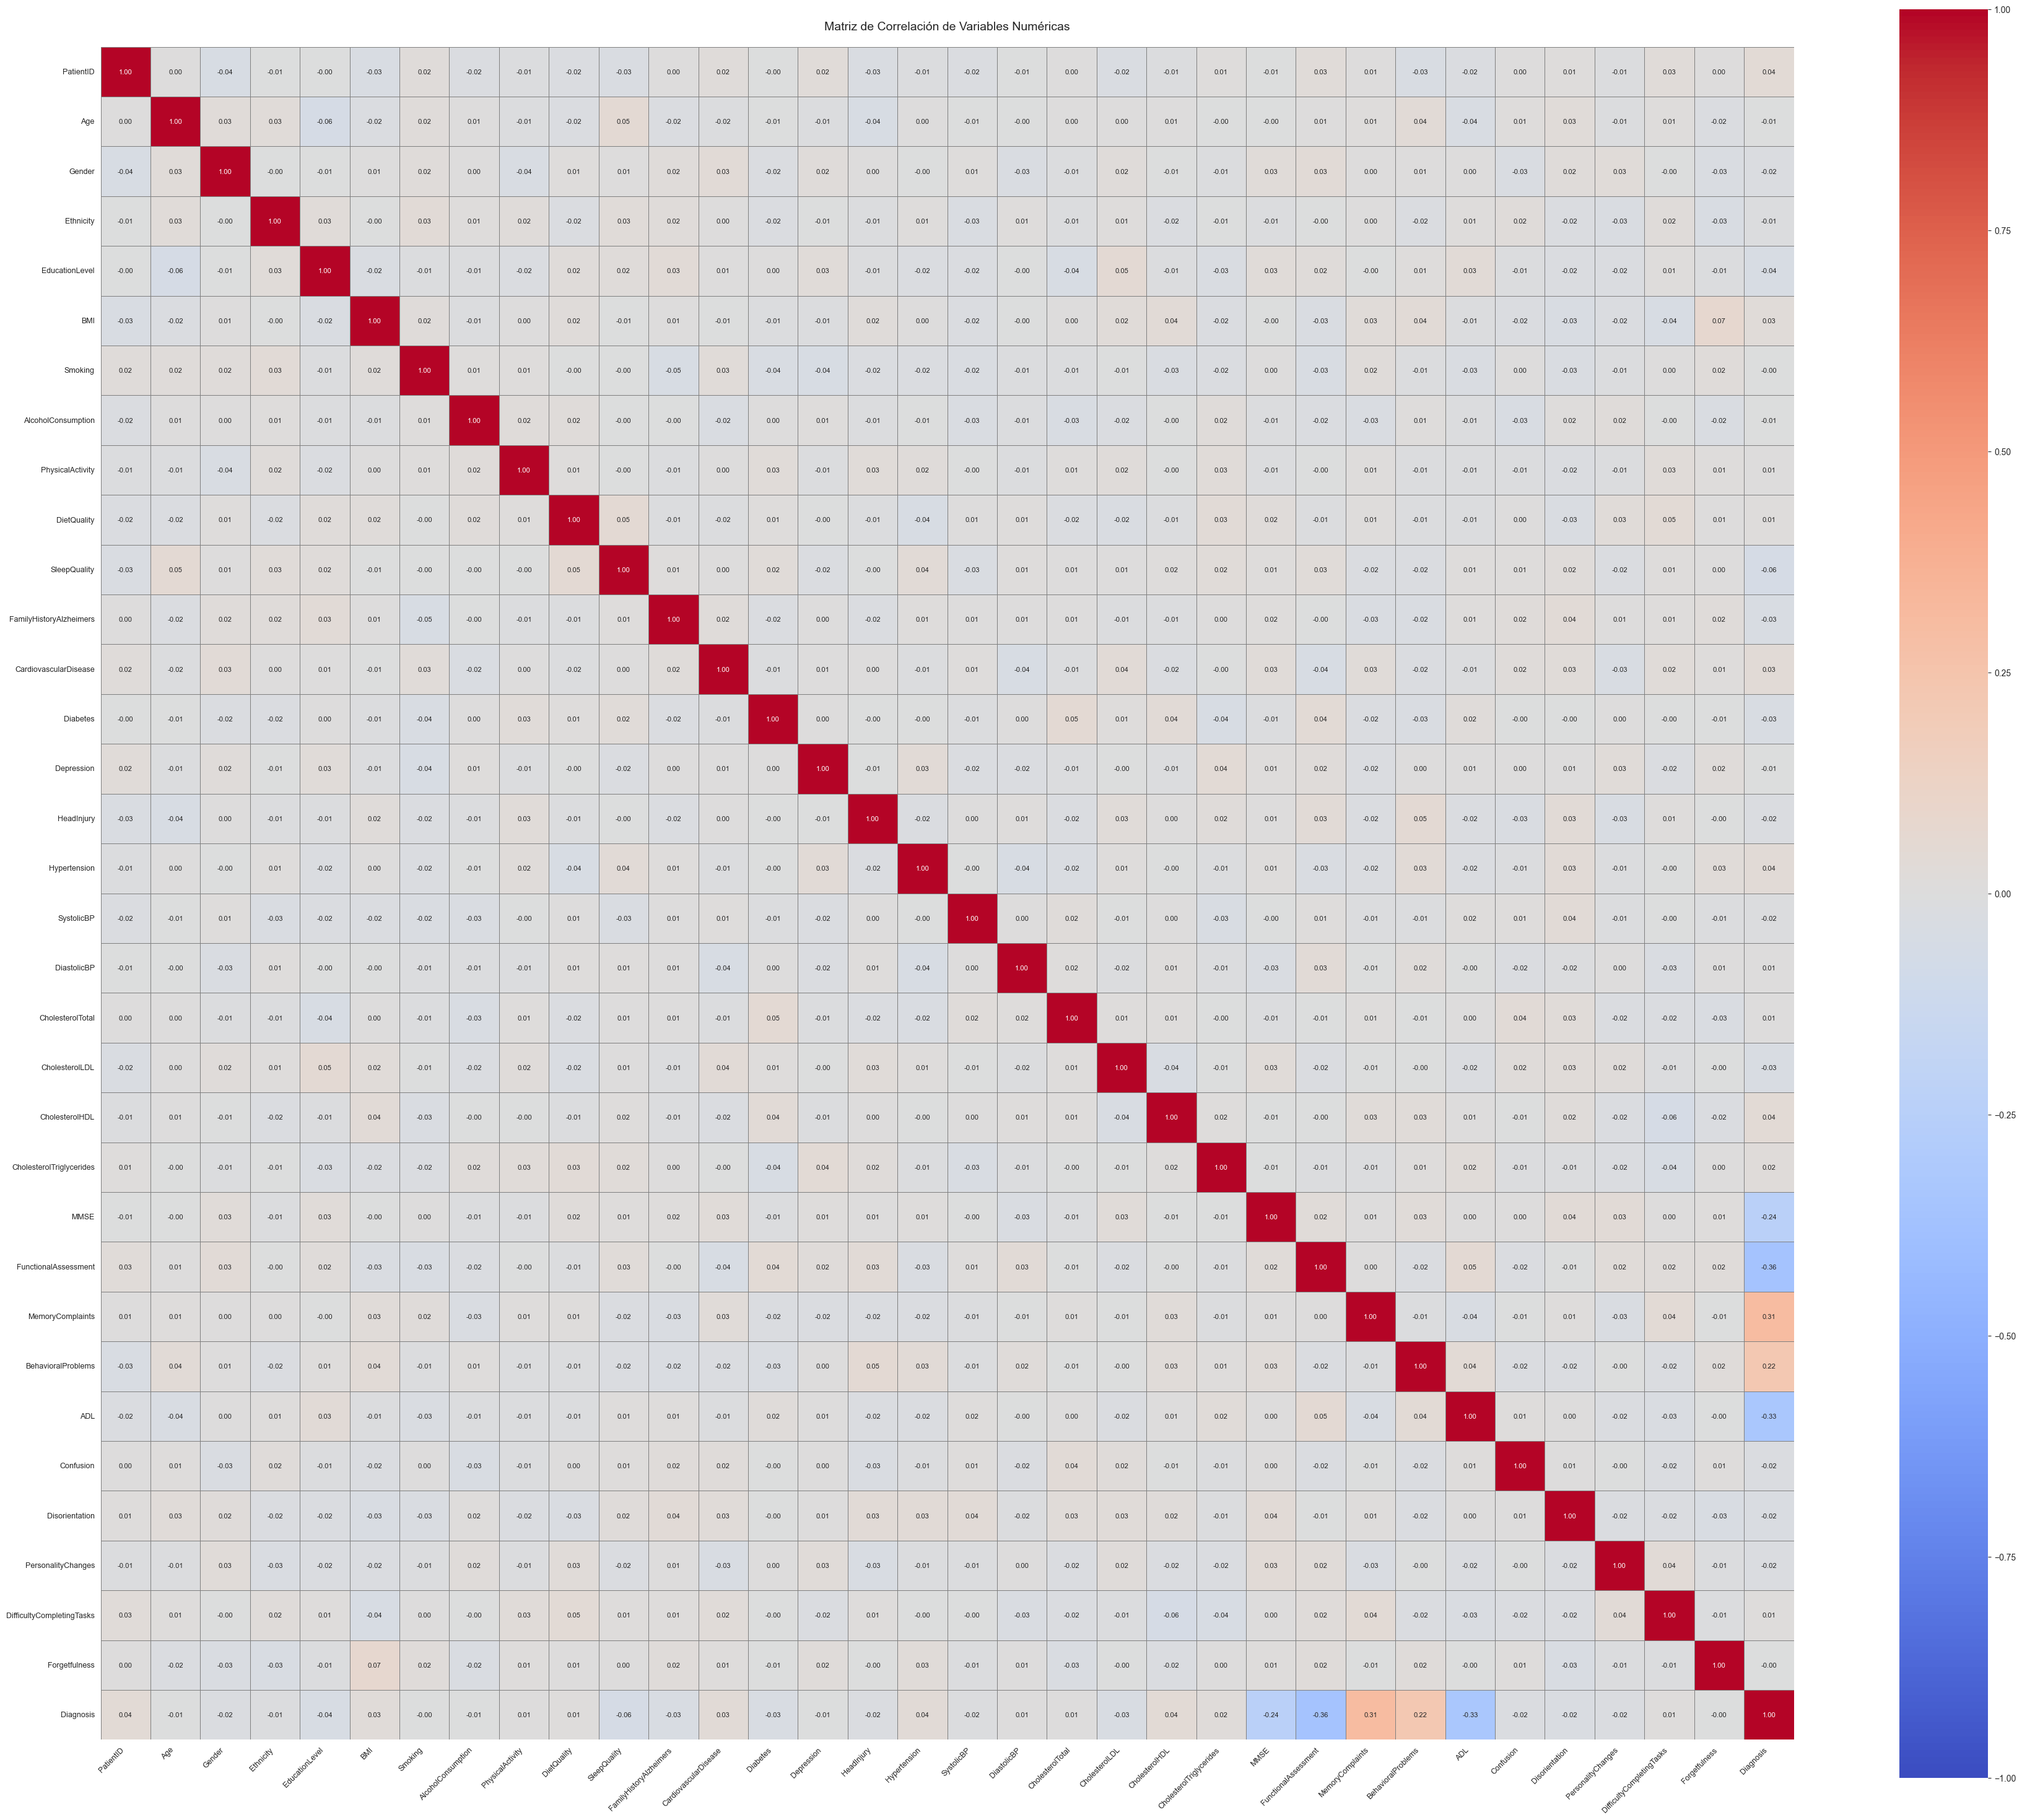


--------------------------------------------------------------------------------
CORRELACIONES FUERTES (|r| > 0.7):
--------------------------------------------------------------------------------

No hay correlaciones fuertes entre variables.


In [19]:
if len(numeric_cols) > 1:
    print("\n" + "="*80)
    print("MATRIZ DE CORRELACIÓN")
    print("="*80 + "\n")
    
    correlation_matrix = df[numeric_cols].corr()
    print(correlation_matrix.round(3))
    
    # Heatmap de correlación - Mejorado para legibilidad
    fig_size = max(14, len(numeric_cols) + 2)
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0, 
                square=True, 
                ax=ax, 
                cbar_kws={"shrink": 0.8},
                vmin=-1, 
                vmax=1,
                annot_kws={"size": 8},
                linewidths=0.5,
                linecolor='gray')
    
    ax.set_title('Matriz de Correlación de Variables Numéricas', fontsize=14, pad=20)
    
    # Rotar etiquetas para mejor legibilidad
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Encontrar correlaciones fuertes (>0.7 o <-0.7)
    print("\n" + "-"*80)
    print("CORRELACIONES FUERTES (|r| > 0.7):")
    print("-"*80 + "\n")
    
    strong_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                strong_corr.append({
                    'Variable 1': correlation_matrix.columns[i],
                    'Variable 2': correlation_matrix.columns[j],
                    'Correlación': correlation_matrix.iloc[i, j].round(3)
                })
    
    if strong_corr:
        strong_corr_df = pd.DataFrame(strong_corr).sort_values('Correlación', key=abs, ascending=False)
        print(strong_corr_df.to_string(index=False))
    else:
        print("No hay correlaciones fuertes entre variables.")
else:
    print("\nNo hay suficientes variables numéricas para calcular correlación.")

## 8.5 Análisis Bivariado con Variable Objetivo

Exploración de la relación entre cada feature y la variable objetivo (Diagnosis).


ANÁLISIS BIVARIADO: FEATURES vs Diagnosis

📊 Distribución de Diagnosis:
0    1389
1     760
Name: Diagnosis, dtype: int64

Proporción:
   Clase 0: 64.6%
   Clase 1: 35.4%

📈 Análisis de Variables Numéricas por Diagnosis:
--------------------------------------------------------------------------------


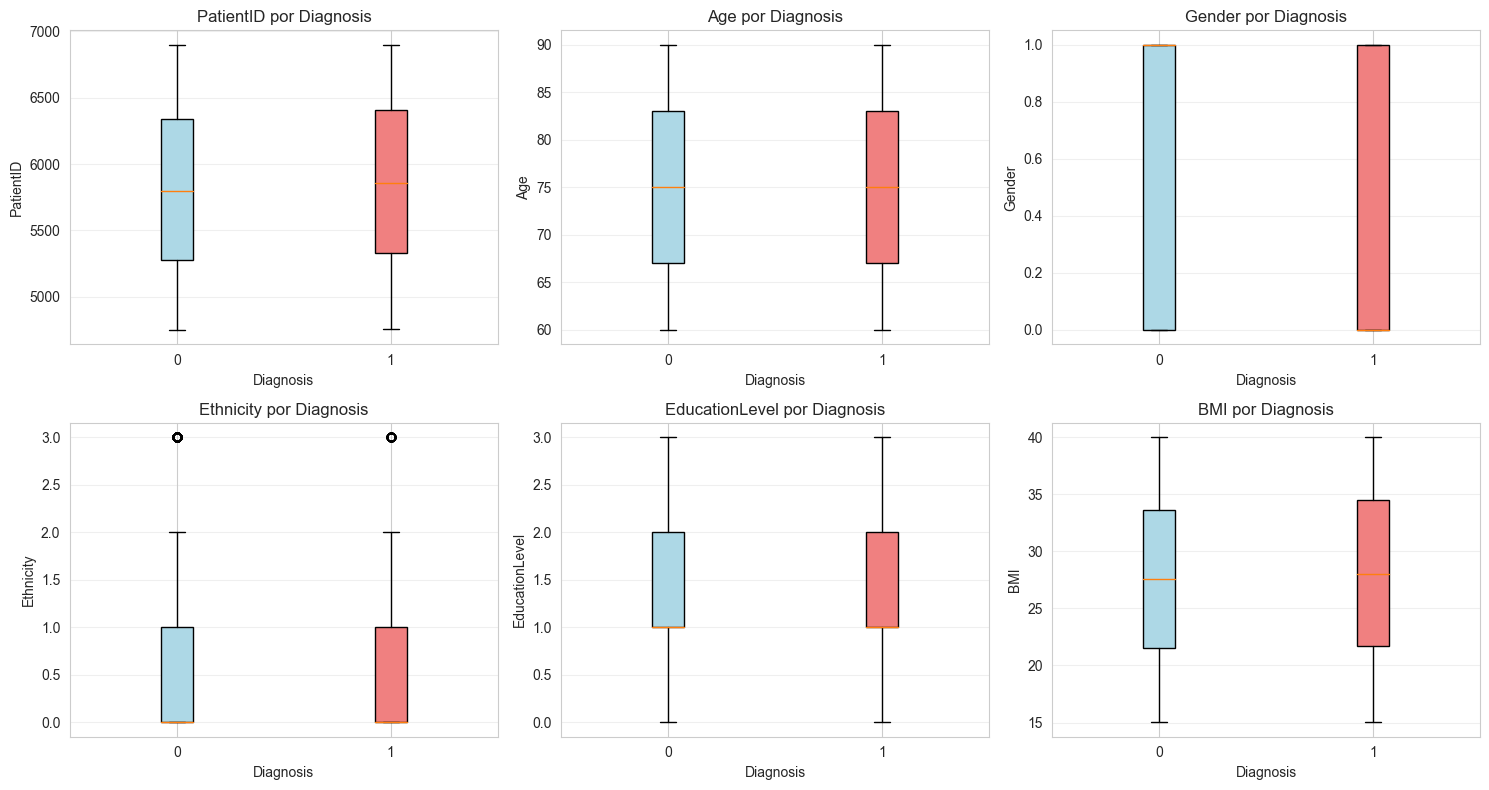


🔬 Tests Estadísticos (t-test para diferencias entre grupos):
--------------------------------------------------------------------------------

PatientID:
   Media Clase 0: 5806.177
   Media Clase 1: 5859.401
   t-statistic: -1.902
   p-value: 0.0573 ns
   ✗ No hay diferencia significativa

Age:
   Media Clase 0: 74.945
   Media Clase 1: 74.842
   t-statistic: 0.254
   p-value: 0.7993 ns
   ✗ No hay diferencia significativa

Gender:
   Media Clase 0: 0.514
   Media Clase 1: 0.492
   t-statistic: 0.972
   p-value: 0.3311 ns
   ✗ No hay diferencia significativa


📊 Análisis de Variables Categóricas por Diagnosis:
--------------------------------------------------------------------------------

DoctorInCharge:
Diagnosis          0    1   All
DoctorInCharge                 
XXXConfid       1389  760  2149
All             1389  760  2149


In [20]:
# Verificar si existe variable objetivo (Diagnosis o similar)
target_col = None
possible_targets = ['Diagnosis', 'diagnosis', 'target', 'Target', 'label', 'Label']

for col in possible_targets:
    if col in df.columns:
        target_col = col
        break

if target_col and target_col in df.columns:
    print("\n" + "="*80)
    print(f"ANÁLISIS BIVARIADO: FEATURES vs {target_col}")
    print("="*80)
    
    # Distribución de la variable objetivo
    print(f"\n📊 Distribución de {target_col}:")
    target_dist = df[target_col].value_counts()
    print(target_dist)
    print(f"\nProporción:")
    for label, count in target_dist.items():
        print(f"   Clase {label}: {count/len(df)*100:.1f}%")
    
    # Análisis de variables numéricas vs target
    if numeric_cols:
        print(f"\n📈 Análisis de Variables Numéricas por {target_col}:")
        print("-"*80)
        
        # Seleccionar hasta 6 variables más importantes (por correlación si existe)
        features_to_analyze = numeric_cols[:min(6, len(numeric_cols))]
        
        n_cols = 3
        n_rows = (len(features_to_analyze) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
        axes = axes.flatten() if len(features_to_analyze) > 1 else [axes]
        
        for idx, col in enumerate(features_to_analyze):
            ax = axes[idx]
            
            # Boxplot por clase
            df_plot = df[[col, target_col]].dropna()
            classes = sorted(df_plot[target_col].unique())
            
            data_by_class = [df_plot[df_plot[target_col] == c][col].values for c in classes]
            
            bp = ax.boxplot(data_by_class, labels=classes, patch_artist=True)
            
            # Colorear boxplots
            colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
            
            ax.set_xlabel(target_col)
            ax.set_ylabel(col)
            ax.set_title(f'{col} por {target_col}')
            ax.grid(alpha=0.3, axis='y')
        
        # Eliminar subplots vacíos
        for idx in range(len(features_to_analyze), len(axes)):
            fig.delaxes(axes[idx])
        
        plt.tight_layout()
        plt.show()
        
        # Tests estadísticos de significancia (ejemplo con primeras 3 variables)
        print(f"\n🔬 Tests Estadísticos (t-test para diferencias entre grupos):")
        print("-"*80)
        
        from scipy import stats
        
        for col in features_to_analyze[:3]:
            df_test = df[[col, target_col]].dropna()
            classes = sorted(df_test[target_col].unique())
            
            if len(classes) == 2:
                # t-test para 2 grupos
                group1 = df_test[df_test[target_col] == classes[0]][col]
                group2 = df_test[df_test[target_col] == classes[1]][col]
                
                t_stat, p_value = stats.ttest_ind(group1, group2)
                
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                
                print(f"\n{col}:")
                print(f"   Media Clase {classes[0]}: {group1.mean():.3f}")
                print(f"   Media Clase {classes[1]}: {group2.mean():.3f}")
                print(f"   t-statistic: {t_stat:.3f}")
                print(f"   p-value: {p_value:.4f} {significance}")
                
                if p_value < 0.05:
                    print(f"   ✓ Diferencia significativa entre grupos")
                else:
                    print(f"   ✗ No hay diferencia significativa")
    
    # Análisis de variables categóricas vs target
    if categorical_cols and target_col not in categorical_cols:
        print(f"\n\n📊 Análisis de Variables Categóricas por {target_col}:")
        print("-"*80)
        
        # Seleccionar primeras 3-4 variables categóricas
        cat_to_analyze = categorical_cols[:min(4, len(categorical_cols))]
        
        for col in cat_to_analyze:
            print(f"\n{col}:")
            
            # Tabla de contingencia
            contingency = pd.crosstab(df[col], df[target_col], margins=True)
            print(contingency)
            
            # Chi-cuadrado test
            if len(df[col].unique()) > 1:
                contingency_no_margins = pd.crosstab(df[col], df[target_col])
                chi2, p_value, dof, expected = stats.chi2_contingency(contingency_no_margins)
                
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                
                print(f"\nChi-cuadrado: {chi2:.3f}, p-value: {p_value:.4f} {significance}")
                
                if p_value < 0.05:
                    print(f"✓ Asociación significativa con {target_col}")
                else:
                    print(f"✗ No hay asociación significativa")
                print("-"*40)
else:
    print("\n⚠️ No se encontró variable objetivo (Diagnosis) en el dataset")
    print("   Si existe con otro nombre, ajustar la variable 'target_col'")


## 8.6 Análisis Multivariado: Pairplot

Exploración de relaciones entre múltiples variables simultáneamente.


ANÁLISIS MULTIVARIADO: PAIRPLOT

📊 Creando pairplot con 6 variables:
   • FunctionalAssessment
   • ADL
   • MemoryComplaints
   • MMSE
   • BehavioralProblems
   • Diagnosis

⏳ Generando pairplot (esto puede tomar unos segundos)...


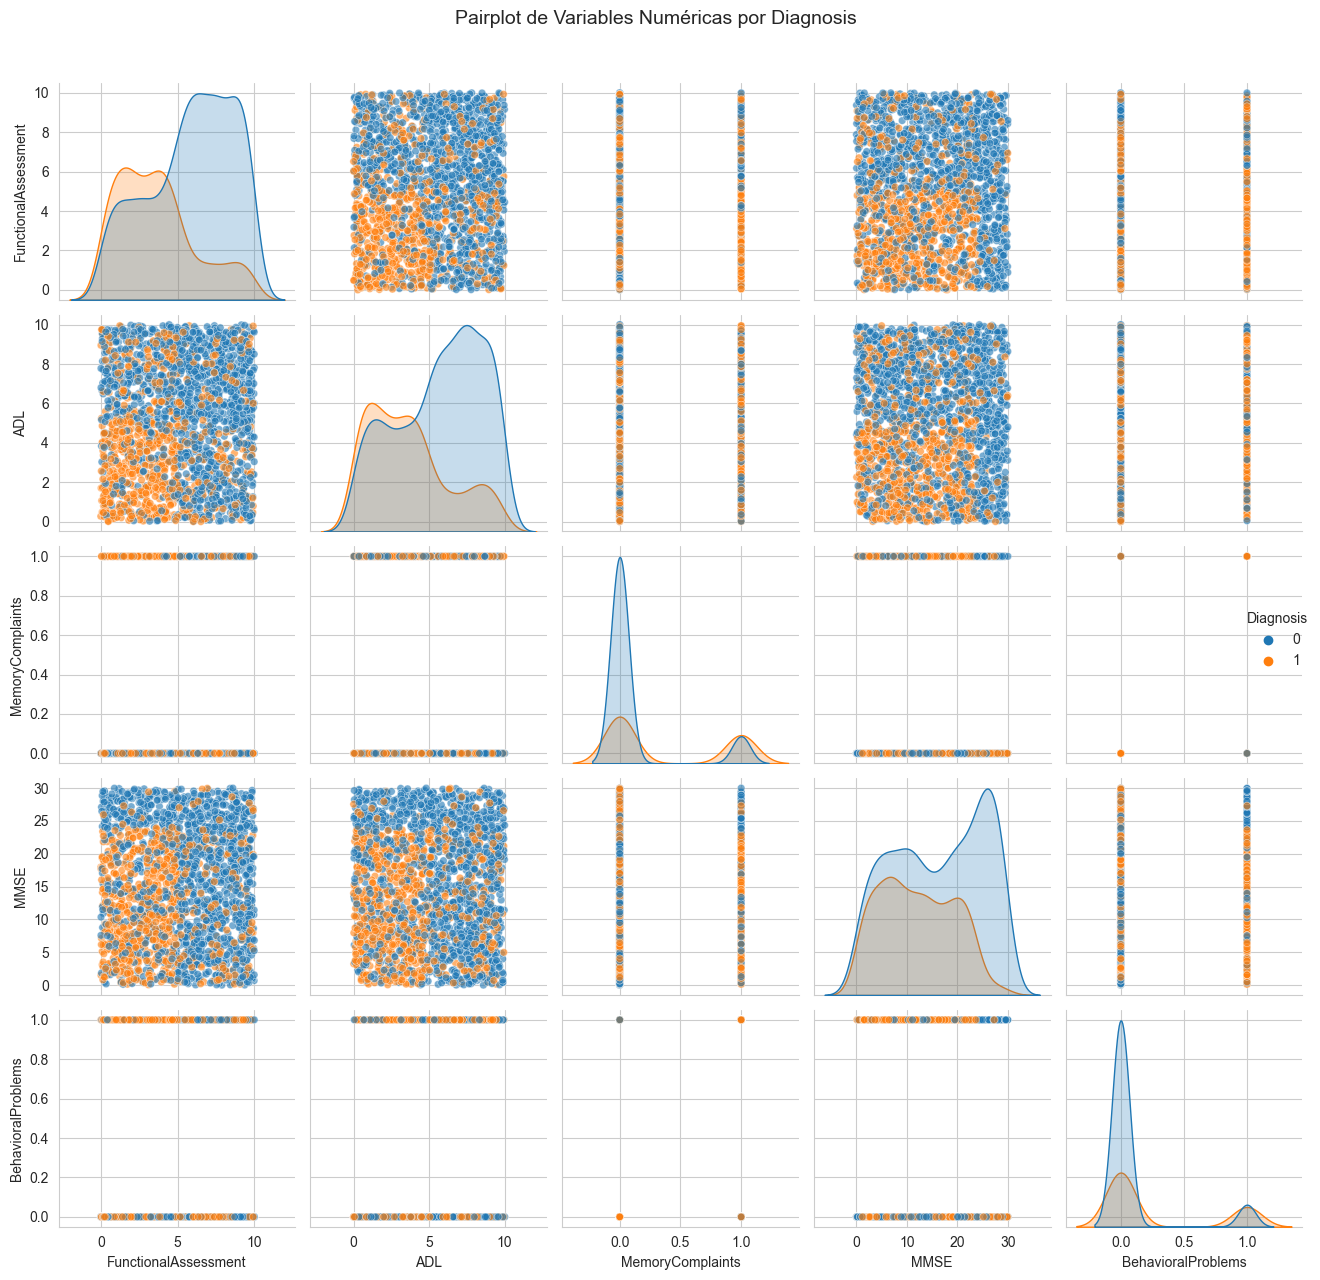


✅ Pairplot completado

💡 Interpretación:
   • Diagonal: Distribución de cada variable
   • Fuera de diagonal: Scatter plots entre pares de variables
   • Colores: Representan diferentes clases de Diagnosis
   • Buscar: Separación clara entre colores indica poder predictivo


In [21]:
if target_col and len(numeric_cols) > 1:
    print("\n" + "="*80)
    print("ANÁLISIS MULTIVARIADO: PAIRPLOT")
    print("="*80)
    
    # Seleccionar top 5-6 variables con mayor correlación con el target (si es numérico)
    # O simplemente las primeras 5-6 variables numéricas
    
    max_features = 5  # Límite para que el pairplot sea legible
    
    if target_col in numeric_cols:
        # Si target es numérico, seleccionar por correlación
        correlations = df[numeric_cols].corr()[target_col].abs().sort_values(ascending=False)
        top_features = correlations[1:max_features+1].index.tolist()  # Excluir el target mismo
        features_for_pairplot = top_features + [target_col]
    else:
        # Si target es categórico, seleccionar primeras N features
        features_for_pairplot = numeric_cols[:min(max_features, len(numeric_cols))]
    
    print(f"\n📊 Creando pairplot con {len(features_for_pairplot)} variables:")
    for feat in features_for_pairplot:
        print(f"   • {feat}")
    
    # Crear subset del dataframe
    df_pairplot = df[features_for_pairplot + ([target_col] if target_col not in features_for_pairplot else [])].dropna()
    
    print(f"\n⏳ Generando pairplot (esto puede tomar unos segundos)...")
    
    # Crear pairplot
    if target_col in df.columns and df[target_col].dtype in ['object', 'int64'] and df[target_col].nunique() <= 5:
        # Si target es categórico con pocas clases, usar como hue
        pairplot = sns.pairplot(
            df_pairplot, 
            hue=target_col,
            diag_kind='kde',
            plot_kws={'alpha': 0.6, 's': 30},
            height=2.5
        )
        pairplot.fig.suptitle(f'Pairplot de Variables Numéricas por {target_col}', y=1.02, fontsize=14)
    else:
        # Si no, pairplot simple
        pairplot = sns.pairplot(
            df_pairplot,
            diag_kind='kde',
            plot_kws={'alpha': 0.6},
            height=2.5
        )
        pairplot.fig.suptitle('Pairplot de Variables Numéricas Principales', y=1.02, fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Pairplot completado")
    print("\n💡 Interpretación:")
    print("   • Diagonal: Distribución de cada variable")
    print("   • Fuera de diagonal: Scatter plots entre pares de variables")
    if target_col in df.columns and df[target_col].dtype in ['object', 'int64'] and df[target_col].nunique() <= 5:
        print(f"   • Colores: Representan diferentes clases de {target_col}")
        print("   • Buscar: Separación clara entre colores indica poder predictivo")
    
elif len(numeric_cols) > 1:
    print("\n⚠️ Variable objetivo no encontrada. Creando pairplot sin clasificación por color.")
    
    features_for_pairplot = numeric_cols[:min(5, len(numeric_cols))]
    df_pairplot = df[features_for_pairplot].dropna()
    
    pairplot = sns.pairplot(df_pairplot, diag_kind='kde', height=2.5)
    pairplot.fig.suptitle('Pairplot de Variables Numéricas', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ No hay suficientes variables numéricas para crear un pairplot")


## 8.7 Sugerencias de Features Derivados

Basado en el análisis exploratorio, se identifican oportunidades para crear características calculadas.

In [22]:
print("\n" + "="*80)
print("FEATURES DERIVADOS POTENCIALES")
print("="*80)

derived_features = []

# Verificar columnas específicas del dataset de Alzheimer
health_indicators = []
lifestyle_indicators = []
cognitive_indicators = []
cardiovascular_indicators = []

# Clasificar columnas por categoría
for col in df.columns:
    col_lower = col.lower()
    
    if any(x in col_lower for x in ['cholesterol', 'bp', 'blood', 'systolic', 'diastolic']):
        cardiovascular_indicators.append(col)
    elif any(x in col_lower for x in ['mmse', 'memory', 'cognitive', 'functional', 'adl', 'confusion']):
        cognitive_indicators.append(col)
    elif any(x in col_lower for x in ['smoking', 'alcohol', 'physical', 'diet', 'sleep', 'bmi']):
        lifestyle_indicators.append(col)
    elif any(x in col_lower for x in ['diabetes', 'hypertension', 'cardiovascular', 'depression']):
        health_indicators.append(col)

print("\n📋 CATEGORÍAS DE VARIABLES IDENTIFICADAS:")
print(f"   • Indicadores de Salud: {len(health_indicators)}")
print(f"   • Indicadores de Estilo de Vida: {len(lifestyle_indicators)}")
print(f"   • Indicadores Cognitivos: {len(cognitive_indicators)}")
print(f"   • Indicadores Cardiovasculares: {len(cardiovascular_indicators)}")

print("\n\n💡 FEATURES DERIVADOS SUGERIDOS:")
print("="*80)

# 1. Ratios de colesterol
if 'CholesterolLDL' in df.columns and 'CholesterolHDL' in df.columns:
    derived_features.append({
        'nombre': 'Cholesterol_Ratio_LDL_HDL',
        'fórmula': 'CholesterolLDL / CholesterolHDL',
        'justificación': 'Indicador de riesgo cardiovascular. Ratio alto asociado con mayor riesgo.',
        'implementación': 'df["Cholesterol_Ratio"] = df["CholesterolLDL"] / df["CholesterolHDL"]'
    })

if 'CholesterolTotal' in df.columns and 'CholesterolHDL' in df.columns:
    derived_features.append({
        'nombre': 'Cholesterol_Total_HDL_Ratio',
        'fórmula': 'CholesterolTotal / CholesterolHDL',
        'justificación': 'Otro indicador cardiovascular. Valores normales < 5.',
        'implementación': 'df["Total_HDL_Ratio"] = df["CholesterolTotal"] / df["CholesterolHDL"]'
    })

# 2. Presión arterial media
if 'SystolicBP' in df.columns and 'DiastolicBP' in df.columns:
    derived_features.append({
        'nombre': 'Mean_Arterial_Pressure',
        'fórmula': 'DiastolicBP + (SystolicBP - DiastolicBP) / 3',
        'justificación': 'Presión arterial media, mejor indicador de perfusión cerebral.',
        'implementación': 'df["MAP"] = df["DiastolicBP"] + (df["SystolicBP"] - df["DiastolicBP"]) / 3'
    })

# 3. IMC categorizado
if 'BMI' in df.columns:
    derived_features.append({
        'nombre': 'BMI_Category',
        'fórmula': 'Categorización: Bajo(<18.5), Normal(18.5-24.9), Sobrepeso(25-29.9), Obeso(>=30)',
        'justificación': 'Categorías clínicas de IMC más interpretables que valor continuo.',
        'implementación': 'pd.cut(df["BMI"], bins=[0, 18.5, 25, 30, 100], labels=["Bajo", "Normal", "Sobrepeso", "Obeso"])'
    })

# 4. Score de riesgo cardiovascular
if health_indicators:
    derived_features.append({
        'nombre': 'Cardiovascular_Risk_Score',
        'fórmula': f'Suma de: {", ".join(health_indicators[:5])}',
        'justificación': 'Agregación de factores de riesgo cardiovascular.',
        'implementación': f'df[{health_indicators[:5]}].sum(axis=1)'
    })

# 5. Score de estilo de vida saludable
if lifestyle_indicators:
    derived_features.append({
        'nombre': 'Healthy_Lifestyle_Score',
        'fórmula': 'Combinación ponderada de hábitos saludables',
        'justificación': 'Agregación de factores de estilo de vida que afectan salud cerebral.',
        'implementación': 'Normalizar y sumar: PhysicalActivity, DietQuality, SleepQuality (invertir Smoking y AlcoholConsumption)'
    })

# 6. Score cognitivo compuesto
if cognitive_indicators:
    derived_features.append({
        'nombre': 'Cognitive_Impairment_Score',
        'fórmula': f'Combinación de: {", ".join(cognitive_indicators[:4])}',
        'justificación': 'Indicador agregado de deterioro cognitivo.',
        'implementación': 'Suma o promedio de indicadores cognitivos'
    })

# 7. Interacciones de edad
if 'Age' in df.columns:
    derived_features.append({
        'nombre': 'Age_Squared',
        'fórmula': 'Age ** 2',
        'justificación': 'Capturar relación no lineal entre edad y riesgo.',
        'implementación': 'df["Age_Squared"] = df["Age"] ** 2'
    })
    
    if 'FamilyHistoryAlzheimers' in df.columns:
        derived_features.append({
            'nombre': 'Age_Family_History_Interaction',
            'fórmula': 'Age * FamilyHistoryAlzheimers',
            'justificación': 'Interacción entre edad y predisposición genética.',
            'implementación': 'df["Age_FH_Interaction"] = df["Age"] * df["FamilyHistoryAlzheimers"]'
        })

# 8. Binning de variables continuas
if 'Age' in df.columns:
    derived_features.append({
        'nombre': 'Age_Group',
        'fórmula': 'Categorías: <65, 65-74, 75-84, 85+',
        'justificación': 'Grupos de edad clínicamente relevantes para Alzheimer.',
        'implementación': 'pd.cut(df["Age"], bins=[0, 65, 75, 85, 120], labels=["<65", "65-74", "75-84", "85+"])'
    })

# Mostrar tabla de features sugeridos
if derived_features:
    print(f"\nTotal de features derivados sugeridos: {len(derived_features)}\n")
    
    for idx, feature in enumerate(derived_features, 1):
        print(f"{idx}. {feature['nombre']}")
        print(f"   Fórmula: {feature['fórmula']}")
        print(f"   Justificación: {feature['justificación']}")
        print(f"   Implementación: {feature['implementación']}")
        print()
    
    print("\n" + "="*80)
    print("RECOMENDACIONES DE IMPLEMENTACIÓN:")
    print("="*80)
    print("""
    1. Implementar estos features en el script 'ft_engineering.py'
    2. Crear una función 'create_derived_features()' antes del preprocesamiento
    3. Validar que los features derivados no tengan valores infinitos o NaN
    4. Evaluar la importancia de estos features después del entrenamiento
    5. Considerar regularización si se agregan muchos features (evitar overfitting)
    """)
    
    # Ejemplo de implementación
    print("\n📝 EJEMPLO DE CÓDIGO PARA IMPLEMENTACIÓN:")
    print("-"*80)
    print("""
def create_derived_features(df):
    '''Crea features derivados basados en análisis EDA'''
    df_new = df.copy()
    
    # Ratio LDL/HDL
    if 'CholesterolLDL' in df.columns and 'CholesterolHDL' in df.columns:
        df_new['Cholesterol_Ratio'] = df_new['CholesterolLDL'] / df_new['CholesterolHDL']
    
    # Presión arterial media
    if 'SystolicBP' in df.columns and 'DiastolicBP' in df.columns:
        df_new['MAP'] = df_new['DiastolicBP'] + (df_new['SystolicBP'] - df_new['DiastolicBP']) / 3
    
    # IMC categorizado
    if 'BMI' in df.columns:
        df_new['BMI_Category'] = pd.cut(df_new['BMI'], 
                                         bins=[0, 18.5, 25, 30, 100], 
                                         labels=['Bajo', 'Normal', 'Sobrepeso', 'Obeso'])
    
    # Edad al cuadrado
    if 'Age' in df.columns:
        df_new['Age_Squared'] = df_new['Age'] ** 2
    
    return df_new
    """)
else:
    print("\n⚠️ No se identificaron oportunidades claras para features derivados.")
    print("   Esto puede deberse a que el dataset no contiene las columnas esperadas.")

print("\n" + "="*80)



FEATURES DERIVADOS POTENCIALES

📋 CATEGORÍAS DE VARIABLES IDENTIFICADAS:
   • Indicadores de Salud: 4
   • Indicadores de Estilo de Vida: 6
   • Indicadores Cognitivos: 5
   • Indicadores Cardiovasculares: 6


💡 FEATURES DERIVADOS SUGERIDOS:

Total de features derivados sugeridos: 10

1. Cholesterol_Ratio_LDL_HDL
   Fórmula: CholesterolLDL / CholesterolHDL
   Justificación: Indicador de riesgo cardiovascular. Ratio alto asociado con mayor riesgo.
   Implementación: df["Cholesterol_Ratio"] = df["CholesterolLDL"] / df["CholesterolHDL"]

2. Cholesterol_Total_HDL_Ratio
   Fórmula: CholesterolTotal / CholesterolHDL
   Justificación: Otro indicador cardiovascular. Valores normales < 5.
   Implementación: df["Total_HDL_Ratio"] = df["CholesterolTotal"] / df["CholesterolHDL"]

3. Mean_Arterial_Pressure
   Fórmula: DiastolicBP + (SystolicBP - DiastolicBP) / 3
   Justificación: Presión arterial media, mejor indicador de perfusión cerebral.
   Implementación: df["MAP"] = df["DiastolicBP"] + (df["

## 9. Resumen Ejecutivo

Conclusiones y recomendaciones generales sobre el dataset.

In [24]:
print("\n" + "="*80)
print("RESUMEN EJECUTIVO DEL EDA")
print("="*80 + "\n")

print(f"📊 Dataset: {data_path}")
print(f"📈 Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"\n🔍 Composición del Dataset:")
print(f"   • Variables numéricas: {len(numeric_cols)}")
print(f"   • Variables categóricas: {len(categorical_cols)}")

# Calidad de datos
pct_missing = (df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100)
print(f"\n⚙️  Calidad de Datos:")
print(f"   • % Valores faltantes totales: {pct_missing:.2f}%")
print(f"   • Rows completas: {len(df.dropna()):,} ({(len(df.dropna())/len(df)*100):.1f}%)")

# Recomendaciones
print(f"\n💡 Recomendaciones:")

if pct_missing > 5:
    print(f"   ⚠️  Alta proporción de valores faltantes ({pct_missing:.2f}%). Considerar:")
    print(f"       - Imputación de valores")
    print(f"       - Eliminación de columnas/filas con muchos faltantes")
else:
    print(f"   ✓ Proporción aceptable de valores faltantes ({pct_missing:.2f}%)")

if len(outlier_summary) > 0:
    print(f"   ⚠️  Se detectaron outliers. Considerar:")
    print(f"       - Análisis causa-efecto de los outliers")
    print(f"       - Posible transformación o remoción")
else:
    print(f"   ✓ No hay outliers significativos detectados")

if len(numeric_cols) > 1 and strong_corr:
    print(f"   💬 Se encontraron {len(strong_corr)} correlación(es) fuerte(s)")
    print(f"       - Revisar multicolinealidad para modelos predictivos")

print(f"\n✅ EDA completado exitosamente")
print("="*80)


RESUMEN EJECUTIVO DEL EDA

📊 Dataset: ../../../alzheimers_disease_data.csv
📈 Dimensiones: 2,149 filas × 35 columnas

🔍 Composición del Dataset:
   • Variables numéricas: 34
   • Variables categóricas: 1

⚙️  Calidad de Datos:
   • % Valores faltantes totales: 0.00%
   • Rows completas: 2,149 (100.0%)

💡 Recomendaciones:
   ✓ Proporción aceptable de valores faltantes (0.00%)
   ⚠️  Se detectaron outliers. Considerar:
       - Análisis causa-efecto de los outliers
       - Posible transformación o remoción

✅ EDA completado exitosamente
